<a href="https://colab.research.google.com/github/s56roy/Fake-News-Classification/blob/main/SVM_and_NN_using_BERTTokenizer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data preparation

In [2]:
!pip install datasets

     |████████████████████████████████| 235kB 7.0MB/s 
     |████████████████████████████████| 112kB 12.2MB/s 
     |████████████████████████████████| 245kB 12.2MB/s 


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from datasets import load_dataset

In [4]:
# download dataset
dataset = load_dataset("datacommons_factcheck", "fctchk_politifact_wapo")

Dataset datacommons_factcheck downloaded and prepared to /root/.cache/huggingface/datasets/datacommons_factcheck/fctchk_politifact_wapo/1.0.0/e3861c84c3e449fb0c316b75997e30bbf723e2ca7f33c668bda07b7436567b35. Subsequent calls will reuse this data.


In [5]:
# convert the dataset into pandas data frame for easy manipulation
pd_data = pd.DataFrame(dataset['train'])

In [6]:
pd_data

,claim_author_name,claim_date,claim_text,review_date,review_rating,review_url,reviewer_name
0,Facebook posts,2019-01-01,"Quotes Michelle Obama as saying, ""White folks ...",2019-01-03,Pants on Fire,https://www.politifact.com/facebook-fact-check...,PolitiFact
1,Ted Cruz,2018-04-11,"Says Facebook shut down a ""Chick-Fil-A Appreci...",2018-04-23,Half True,https://www.politifact.com/texas/statements/20...,PolitiFact
2,Donald Trump,2018-06-12,"""We haven’t given up anything other than … I a...",2018-06-12,Will military drills end?,http://www.politifact.com/truth-o-meter/articl...,PolitiFact
3,Various websites,2017-09-03,"""BREAKING: 2 Democrat Congressmen On ISIS Payr...",2017-10-26,False,https://www.factcheck.org/2017/10/no-isis-arre...,FactCheck.org
4,James Woods,2016-08-27,"The ""Dallas Cowboys can’t put a sticker on the...",2016-09-01,True,https://www.politifact.com/texas/statements/20...,PolitiFact
...,...,...,...,...,...,...,...
5627,Wisconsin Republican Party,,Claims that Democratic candidate for governor ...,2018-08-10,Half True,https://www.politifact.com/wisconsin/statement...,PolitiFact
5628,Various websites,2018-05-01,"""Clint Eastwood Leaves His Estate To The Trump...",2018-05-08,False,https://www.factcheck.org/2018/05/eastwood-not...,FactCheck.org
5629,Donald Trump,2017-11-27,"""You were here long before any of us were here...",2017-11-27,Needs Context,https://www.washingtonpost.com/news/fact-check...,Washington Post
5630,Mick Mulvaney,2019-01-06,"""We had arrested 17,000 criminals at the south...",2019-01-08,Misleading,https://www.factcheck.org/2019/01/misleading-b...,FactCheck.org


In [7]:
pd_data.describe()

,claim_author_name,claim_date,claim_text,review_date,review_rating,review_url,reviewer_name
count,5632,5632,5632,5632,5632,5632,5632
unique,1628,1307,5603,906,391,5632,4
top,Donald Trump,2016-09-26,"""I never said Russia did not meddle in the ele...",2016-07-15,False,https://www.politifact.com/truth-o-meter/state...,PolitiFact
freq,1263,24,3,68,1304,1,3975


In [8]:
# drop `NaN` rows
pd_data = pd_data.dropna(axis=0)

In [9]:
value_counts=pd_data['review_rating'].value_counts(normalize=True)*100

In [10]:
pd_data['review_rating'].describe()

count      5632
unique      391
top       False
freq       1304
Name: review_rating, dtype: object

In [12]:
# Select the values where the count is less than 5
to_remove = value_counts[value_counts <= 5].index

In [13]:
# Keep rows where the city column is not in to_remove
df = pd_data[~pd_data.review_rating.isin(to_remove)]
df

,claim_author_name,claim_date,claim_text,review_date,review_rating,review_url,reviewer_name
0,Facebook posts,2019-01-01,"Quotes Michelle Obama as saying, ""White folks ...",2019-01-03,Pants on Fire,https://www.politifact.com/facebook-fact-check...,PolitiFact
1,Ted Cruz,2018-04-11,"Says Facebook shut down a ""Chick-Fil-A Appreci...",2018-04-23,Half True,https://www.politifact.com/texas/statements/20...,PolitiFact
3,Various websites,2017-09-03,"""BREAKING: 2 Democrat Congressmen On ISIS Payr...",2017-10-26,False,https://www.factcheck.org/2017/10/no-isis-arre...,FactCheck.org
4,James Woods,2016-08-27,"The ""Dallas Cowboys can’t put a sticker on the...",2016-09-01,True,https://www.politifact.com/texas/statements/20...,PolitiFact
5,National Republican Congressional Committee,2016-08-10,"Tom Suozzi raised taxes ""by hundreds of millio...",2016-09-23,True,https://www.politifact.com/new-york/statements...,PolitiFact
...,...,...,...,...,...,...,...
5624,Newt Gingrich,2011-06-15,Every 10th dollar spent by the Social Security...,2016-07-15,Mostly True,https://www.politifact.com/georgia/statements/...,PolitiFact
5626,Scott Walker,2017-07-19,"""We took Wisconsin from the Bottom 10 for busi...",2017-08-23,Mostly False,https://www.politifact.com/wisconsin/statement...,PolitiFact
5627,Wisconsin Republican Party,,Claims that Democratic candidate for governor ...,2018-08-10,Half True,https://www.politifact.com/wisconsin/statement...,PolitiFact
5628,Various websites,2018-05-01,"""Clint Eastwood Leaves His Estate To The Trump...",2018-05-08,False,https://www.factcheck.org/2018/05/eastwood-not...,FactCheck.org


In [14]:
#Chceking
df['review_rating'].value_counts(normalize=True)*100
#The new data has only 6 features ( with the others dropped the fequencies has increased)

False            30.878522
Mostly False     15.889178
Pants on Fire    15.770779
Half True        15.273502
Mostly True      14.065830
True              8.122188
Name: review_rating, dtype: float64

In [110]:
# create a new column: 'category' for binary classification
df['category'] = df['review_rating'].apply(lambda x: 'True' if x in ['True', 'Mostly True', 'Half True', 'Pants on Fire'] else 'Fake')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [111]:

# create a new column: 'claim' by merging 3 columns
df['claim'] = df['claim_author_name'] + [' '] * len(df) + df['claim_text'] + [' '] * len(df) + df['reviewer_name']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
# finalized data
final_data = df[['claim', 'category']]

In [113]:
final_data

,claim,category
0,Facebook posts Quotes Michelle Obama as saying...,True
1,"Ted Cruz Says Facebook shut down a ""Chick-Fil-...",True
3,"Various websites ""BREAKING: 2 Democrat Congres...",Fake
4,"James Woods The ""Dallas Cowboys can’t put a st...",True
5,National Republican Congressional Committee To...,True
...,...,...
5624,Newt Gingrich Every 10th dollar spent by the S...,True
5626,"Scott Walker ""We took Wisconsin from the Botto...",Fake
5627,Wisconsin Republican Party Claims that Democra...,True
5628,"Various websites ""Clint Eastwood Leaves His Es...",Fake


In [114]:
final_data.describe()

,claim,category
count,4223,4223
unique,4222,2
top,"Donald Trump ""Drug prices are coming down, fir...",True
freq,2,2248


In [115]:
df['category'].value_counts(normalize=True)*100

True    53.232299
Fake    46.767701
Name: category, dtype: float64

In [116]:
final_data.to_csv("cleaned_data.csv")

# 2. Building classifier

In [117]:
!pip install transformers

In [118]:
import string
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf

import matplotlib.pyplot as plt

In [119]:
# the model we gonna train, base uncased BERT
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 80

In [120]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [121]:
encoder = LabelEncoder()

# label encoding the categories. After this each category would be mapped to an integer.
final_data['category'] = encoder.fit_transform(final_data['category'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [122]:
import re
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    all_list = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(all_list)
    return clean_text

final_data['claim'] = final_data['claim'].apply(clean_txt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [139]:
final_data.to_csv("cleaned_balanced_data.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbdaf1cd0>]],
      dtype=object)

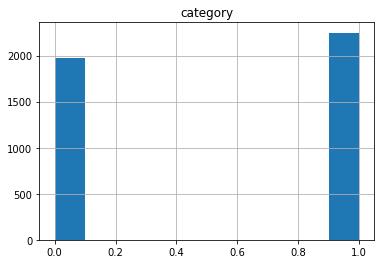

In [124]:
final_data.hist('category')

In [125]:
# split the dataset into train and test dataset by the ratio of 0.2
X_train,X_test,y_train,y_test = train_test_split(
    final_data['claim'],
    final_data['category'],
    test_size=0.2, random_state=42
)

In [126]:
def regular_encode(texts, tokenizer, maxlen):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [127]:
# tokenizing the news descriptions
Xtrain_encoded = regular_encode(X_train.values.tolist(), tokenizer, maxlen=max_length)
Xtest_encoded = regular_encode(X_test.values.tolist(), tokenizer, maxlen=max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [128]:
# normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtrain_encoded)
X_test = scaler.transform(Xtest_encoded)

In [129]:
# classifier
model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=(max_length, )),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [130]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 3,661
Trainable params: 3,661
Non-trainable params: 0
_________________________________________________________________


In [131]:
# class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(y_train),
    y_train
)

In [132]:
class_weights = dict(enumerate(class_weights))

In [133]:
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    return -tf.keras.backend.sum(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.keras.backend.log(pt_1)) - tf.keras.backend.sum((1-alpha) * tf.keras.backend.pow( pt_0, gamma) * tf.keras.backend.log(1. - pt_0))

In [134]:
# compile the classifier
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.BinaryCrossentropy(),
              loss = [focal_loss],
              metrics=['accuracy'],
)

In [135]:
# train the classifier
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    shuffle=True,
    class_weight=class_weights
)

Epoch 1/100
106/106 [==============================] - 1s 3ms/step - loss: 3.1092 - accuracy: 0.5130 - val_loss: 2.8872 - val_accuracy: 0.4935
Epoch 2/100
106/106 [==============================] - 0s 2ms/step - loss: 2.8082 - accuracy: 0.5089 - val_loss: 2.7602 - val_accuracy: 0.4852
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 2.6766 - accuracy: 0.5006 - val_loss: 2.6877 - val_accuracy: 0.4911
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 2.5975 - accuracy: 0.4956 - val_loss: 2.6301 - val_accuracy: 0.4982
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 2.5373 - accuracy: 0.4973 - val_loss: 2.5859 - val_accuracy: 0.4864
Epoch 6/100
106/106 [==============================] - 0s 2ms/step - loss: 2.4909 - accuracy: 0.4985 - val_loss: 2.5503 - val_accuracy: 0.4852
Epoch 7/100
106/106 [==============================] - 0s 2ms/step - loss: 2.4483 - accuracy: 0.4962 - val_loss: 2.5236 - val_accuracy: 0.4864

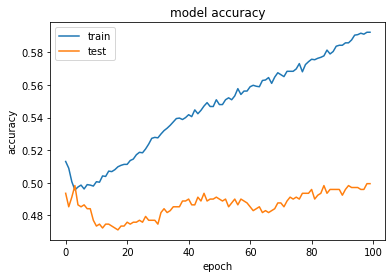

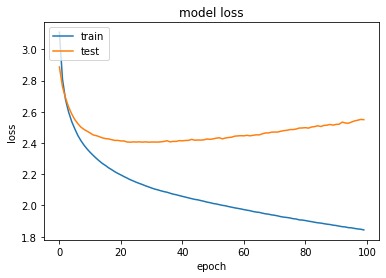

In [136]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 3. Inference

In [138]:
# inference using the trained classifier
an_input = Xtrain_encoded[3]
output = model.predict(scaler.transform(np.expand_dims(an_input, 0)))
result = "True" if output[0][0] > 0.5 else "Fake"
print(">>> Result: ", result)

>>> Result:  Fake


# 4. report

In [104]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [105]:
pred = model.predict(X_test)

In [106]:
pred_classes = np.array([1 if i[0] > 0.5 else 0 for i in pred])

In [107]:
confusion_matrix(y_test.values, pred_classes)

array([[666,   0],
       [179,   0]])

In [108]:
print(classification_report(y_test.values, pred_classes))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       666
           1       0.00      0.00      0.00       179

    accuracy                           0.79       845
   macro avg       0.39      0.50      0.44       845
weighted avg       0.62      0.79      0.69       845



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Other model

In [74]:
# SVM

In [63]:
from sklearn.svm import SVC

In [64]:
clf = SVC(random_state=0)

In [65]:
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [66]:
pred = clf.predict(X_test)

In [67]:
accuracy_score(y_test, pred)

0.6236686390532544